In [ ]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [ ]:
with zipfile.ZipFile('/content/FemurTibiaBoneMasks197.zip', 'r') as zip_ref:
    zip_ref.extractall('./preds')

## Step1: Single Image slice working algorithm

In [ ]:
def measure_distance(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # binary = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]

    contour_areas = [cv2.contourArea(c) for c in contours]
    print("Contour areas:", contour_areas)

    if len(contours) < 2:
        raise ValueError(f"Less than two bone components detected! Found {len(contours)} contours.")

    points_femur = contours[0]
    points_tibia = contours[1]
    distances = []
    for pf in points_femur:
        for pt in points_tibia:
            dist = np.linalg.norm(pf[0] - pt[0])
            # dist = np.linalg.norm(pf - pt)
            distances.append(dist)
    min_distance = np.min(distances)
    avg_distance = np.mean(distances)
    return min_distance, avg_distance

In [ ]:
image = cv2.imread("/content/preds/preds/9002116_059_pred.png")
print(image.shape)

(384, 384, 3)


In [ ]:
image_path = "/content/preds/preds/9002116_059_pred.png"
# min_dist, avg_dist = measure_distance_skimage(image_path)
min_dist, avg_dist = measure_distance(image_path)
print(f"Minimum Distance: {min_dist}")
print(f"Average Distance: {avg_dist}")

Contour areas: [25455.0, 14978.0]
Minimum Distance: 6.708203932499369
Average Distance: 183.07058386563187


✊

*   Test for different variation of image
*   Copy the code if needed and improve it below with comments



## Step2: Single Image slice working algorithm

In [ ]:
def is_valid_slice(image, size_threshold=500):
    # _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > size_threshold]
    return len(large_contours) >= 2

def find_valid_slices(slice_paths, size_threshold=500):
    valid_slices = []
    for i, path in enumerate(slice_paths):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if is_valid_slice(image, size_threshold):
            valid_slices.append(i)
    if valid_slices:
        start_slice = valid_slices[0]
        end_slice = valid_slices[-1]
        return start_slice, end_slice, valid_slices
    else:
        raise ValueError("No valid slices found with both femur and tibia bones.")

def sample_slices(valid_slices, step=2):
    return valid_slices[::step]

slice_paths = [f"/content/preds/preds/9002116_{i:03d}_pred.png" for i in range(160)]
start, end, valid_slices = find_valid_slices(slice_paths)
sampled_slices = sample_slices(valid_slices)

print(f"Valid slices range: {start} to {end}")
print(f"Sampled slices: {sampled_slices}")
print(f"Number of valid slices: {len(valid_slices)}")
print(f"Number of sampled slices: {len(sampled_slices)}")

Valid slices range: 10 to 143
Sampled slices: [10, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143]
Number of valid slices: 117
Number of sampled slices: 59


## Step3: Collaborated Step1 and Step2

In [ ]:
def is_valid_slice(image, size_threshold=500):
    # _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > size_threshold]
    return len(large_contours) >= 2

def find_valid_slices(slice_paths, size_threshold=500):
    valid_slices = []
    for i, path in enumerate(slice_paths):
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if is_valid_slice(image, size_threshold):
            valid_slices.append(i)
    if valid_slices:
        start_slice = valid_slices[0]
        end_slice = valid_slices[-1]
        return start_slice, end_slice, valid_slices
    else:
        raise ValueError("No valid slices found.")

def sample_slices(valid_slices, step=1):
    return valid_slices[::step]

def measure_distance(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    if len(contours) < 2:
        return None
    distances = [
        np.linalg.norm(pf[0] - pt[0])
        for pf in contours[0]
        for pt in contours[1]
    ]
    return np.mean(distances)

In [ ]:
def process_dataset(folder_path, step=1, size_threshold=500, output_file="feature_vectors.csv"):
    feature_vectors = {}
    patient_ids = set(f.split('_')[0] for f in os.listdir(folder_path) if f.endswith(".png"))

    for patient_id in tqdm(patient_ids, desc="Processing Cases"):
        slice_paths = sorted(
            [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.startswith(patient_id)],
            key=lambda x: int(x.split('_')[1])  # Sort by slice number
        )

        try:
            _, _, valid_slices = find_valid_slices(slice_paths, size_threshold)
        except ValueError:
            print(f"Skipping patient {patient_id}: No valid slices.")
            continue

        sampled_slices = sample_slices(valid_slices, step)

        distances = []
        for idx in sampled_slices:
            distance = measure_distance(slice_paths[idx])
            if distance is not None:
                distances.append(distance)

        feature_vectors[patient_id] = distances

    max_length = max(len(v) for v in feature_vectors.values())
    for pid in feature_vectors:
        feature_vectors[pid] += [0] * (max_length - len(feature_vectors[pid]))

    df = pd.DataFrame.from_dict(feature_vectors, orient="index")
    df.to_csv(output_file, index_label="PatientID")
    print(f"Feature vectors saved to {output_file}")

In [ ]:
dataset_folder = "/content/preds/preds/"
process_dataset(dataset_folder)

Processing Cases: 100%|██████████| 198/198 [38:33<00:00, 11.69s/it]

Feature vectors saved to feature_vectors.csv


## Step4: Using both label CSV and feature vectors csv and ML ROC

In [ ]:
# Load datasets
df_baseline = pd.read_csv("/content/KL grade for baseline year and 2-year follow up.csv")
df_features = pd.read_csv("/content/feature_vectors_1.csv")

In [ ]:
df_features.tail(50)

,PatientID,0,1,2,3,4,5,6,7,8,...,132,133,134,135,136,137,138,139,140,141
148,9770617,106.360117,108.093939,108.858745,109.235333,114.670052,115.721500,105.754960,114.787041,125.046808,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
149,9031141,69.214327,96.567226,104.193785,108.909473,108.907327,116.371782,125.577366,123.454454,127.272962,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
150,9858252,252.196324,120.895997,115.043638,120.505226,124.083754,127.095378,113.237517,115.270855,119.631009,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
151,9883115,102.546360,112.193758,112.272996,115.005119,112.669059,102.951030,112.043736,119.382144,125.114699,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
152,9637676,150.468964,150.372032,144.498938,169.083962,61.702606,63.706738,178.542155,206.890976,195.033815,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
153,9033275,87.368227,92.914778,97.468372,95.829469,101.246260,101.112427,101.627164,102.636918,106.496530,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
154,9843845,174.720764,117.799205,117.373805,120.511870,120.876290,126.566333,121.728840,122.951302,123.841400,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
155,9847873,173.328664,223.180027,214.609268,229.048957,276.084360,58.735656,81.770544,84.982635,89.614474,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
156,9469520,101.333277,108.465590,107.091919,118.219669,113.545738,120.099578,126.982151,131.046268,134.286352,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
157,9467311,42.437396,68.751071,68.451085,65.471403,95.541602,96.994086,95.366053,95.380686,96.402533,...,104.613303,238.722288,230.66703,235.828021,218.752186,192.200269,184.125114,179.858577,0.0,0.0


In [ ]:
print(df_baseline.columns)

Index(['cases', 'V00XRKL', 'V03KL', 'Unnamed: 3'], dtype='object')


In [ ]:
print(df_features.columns)

Index(['PatientID', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '132', '133', '134', '135', '136', '137', '138', '139', '140', '141'],
      dtype='object', length=143)


In [ ]:
df_baseline.rename(columns={'cases': 'Patient_ID'}, inplace=True)
df_features.rename(columns={'PatientID': 'Patient_ID'}, inplace=True)

In [ ]:
df = pd.merge(df_baseline, df_features, on="Patient_ID")

In [ ]:
print(df.columns)

Index(['Patient_ID', 'V00XRKL', 'V03KL', 'Unnamed: 3', '0', '1', '2', '3', '4',
       '5',
       ...
       '132', '133', '134', '135', '136', '137', '138', '139', '140', '141'],
      dtype='object', length=146)


In [ ]:
df = df.drop(columns=['Unnamed: 3'])

In [ ]:
print(df.columns)

Index(['Patient_ID', 'V00XRKL', 'V03KL', '0', '1', '2', '3', '4', '5', '6',
       ...
       '132', '133', '134', '135', '136', '137', '138', '139', '140', '141'],
      dtype='object', length=145)


In [ ]:
print(df.shape)

(197, 145)


In [ ]:
df

,Patient_ID,V00XRKL,V03KL,0,1,2,3,4,5,6,...,132,133,134,135,136,137,138,139,140,141
0,9002116,3,B,78.954095,62.272079,90.712291,93.222279,97.927831,98.134542,101.303520,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9005075,0,A,157.653149,82.144416,207.133670,117.303268,117.872926,120.197636,113.551075,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9005132,4,B,68.357973,174.682935,178.360173,184.791851,182.781961,181.131302,98.311261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9026934,2,A,151.640343,156.318550,60.082639,130.205480,139.977309,93.900750,99.913182,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9030718,3,B,122.121593,104.346670,107.310218,118.264095,120.899162,122.817098,123.406306,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,9981798,1,B,102.734779,102.831006,105.985414,114.812015,115.603537,107.778782,114.901417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,9988421,0,A,102.021877,253.246746,143.075450,125.549451,124.458864,123.629346,133.556203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,9990072,1,A,96.104377,98.670619,102.266389,106.578061,111.430701,117.924102,119.718325,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,9991313,4,B,63.829113,55.905747,89.398125,94.365231,92.991510,91.811312,90.877600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ran a code to understand the feature importance, and created an updated_df with the actual values + filled all the 0s/NaN values with the average of the particular row (means the average distance of bones of the patient).

In [ ]:
# Prepare data for feature importance
X = df.drop(columns=['Patient_ID', 'V00XRKL', 'V03KL'])
y = df['V00XRKL']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

threshold = 0.01 # Adjust as needed
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()

updated_df = df[['Patient_ID', 'V00XRKL', 'V03KL'] + important_features]
updated_df

,Patient_ID,V00XRKL,V03KL,56,30,55,1,0,2,22,...,80,26,36,65,53,51,28,44,18,67
0,9002116,3,B,174.683431,175.575732,167.720896,62.272079,78.954095,90.712291,145.687785,...,191.803821,174.816766,181.311495,171.605022,166.513949,173.345548,175.749928,167.401590,133.258828,179.380771
1,9005075,0,A,188.688654,184.508837,182.738190,82.144416,157.653149,207.133670,179.532789,...,189.837244,174.790320,190.271930,185.820144,185.194603,182.368389,175.013673,181.232954,157.017976,185.252794
2,9005132,4,B,176.115146,155.590954,167.719130,174.682935,68.357973,178.360173,136.178132,...,181.233805,153.813633,170.073834,158.029975,169.573822,174.748619,153.681678,183.122334,130.796293,157.138486
3,9026934,2,A,186.031525,194.434195,187.716386,156.318550,151.640343,60.082639,151.339781,...,181.540384,172.010084,190.055042,173.299605,180.268188,176.257216,179.687434,177.052871,139.076419,166.730846
4,9030718,3,B,180.101193,179.131257,178.478519,104.346670,122.121593,107.310218,159.503730,...,185.288116,186.906618,183.633850,193.447365,177.035239,179.089794,179.829381,168.198116,145.181536,201.499051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,9981798,1,B,180.300768,165.888338,169.632167,102.831006,102.734779,105.985414,162.957770,...,184.106912,169.073942,169.693230,175.656886,175.681734,178.090112,169.586793,192.474470,162.832572,187.476949
193,9988421,0,A,175.144496,185.415415,179.106331,253.246746,102.021877,143.075450,163.734956,...,166.174810,185.366140,177.390151,181.918328,187.020545,175.859760,193.331859,176.784082,154.897567,184.484851
194,9990072,1,A,175.401009,180.350983,175.079871,98.670619,96.104377,102.266389,175.567828,...,141.999663,189.918995,173.726774,177.164214,176.605131,188.429429,187.082930,173.405231,161.419524,170.513288
195,9991313,4,B,196.142423,179.614552,197.735021,55.905747,63.829113,89.398125,184.114449,...,149.049686,182.149443,179.913282,195.047281,195.579593,192.093241,187.885783,183.147759,185.085555,188.320907


In [ ]:
updated_df.describe()

,Patient_ID,V00XRKL,56,30,55,1,0,2,22,45,...,80,26,36,65,53,51,28,44,18,67
count,1.970000e+02,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,...,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,9.544277e+06,2.487310,177.453801,181.461420,176.560344,112.766759,111.426660,113.192460,163.836719,177.575116,...,168.535839,175.601591,181.567618,178.214907,177.925860,177.581549,178.817349,178.017101,149.623963,177.390140
std,2.790811e+05,1.256043,11.543356,12.600806,10.392716,42.250870,47.834744,34.626832,16.114883,10.470943,...,29.343617,13.994142,11.611700,13.185263,10.409314,9.592174,13.316740,10.587899,16.200340,16.746781
min,9.002116e+06,0.000000,129.375270,128.218527,138.366638,45.376695,40.731499,45.361141,110.292018,129.540119,...,0.000000,115.703885,126.435134,67.407863,137.589431,136.752494,121.444696,136.448475,102.409078,0.000000
25%,9.372474e+06,2.000000,171.934337,174.749029,171.460456,88.143635,73.563708,94.430828,154.839516,172.321234,...,157.553909,167.497483,175.096250,172.753367,172.175377,172.065533,171.767332,171.770642,138.125397,172.712803
50%,9.568974e+06,3.000000,176.614760,182.293046,175.927157,104.655033,103.339821,106.404932,164.901715,178.595189,...,177.150889,176.687318,181.342301,177.803275,177.927825,176.854532,180.268415,177.865580,149.459379,178.966604
75%,9.785243e+06,4.000000,184.354336,190.041763,182.698002,125.432153,128.424082,120.144256,174.724377,183.255763,...,188.196725,186.050308,188.842780,183.843657,183.540244,183.069500,187.885783,185.032093,159.536042,183.812524
max,9.997856e+06,4.000000,230.931146,208.640218,227.333958,321.906207,310.114730,291.895422,201.604017,202.864934,...,205.267676,202.018446,205.253330,230.116517,225.287894,227.454706,203.477426,210.376037,200.676548,202.802661


In [ ]:
import warnings
warnings.filterwarnings('ignore')

for index, row in updated_df.iterrows():
    row_average = row.iloc[3:].replace(0, np.nan).mean()
    if np.isnan(row_average):
      row_average = 0
    updated_df.iloc[index, 3:] = row.iloc[3:].replace(0, row_average)

updated_df

,Patient_ID,V00XRKL,V03KL,56,30,55,1,0,2,22,...,80,26,36,65,53,51,28,44,18,67
0,9002116,3,B,174.683431,175.575732,167.720896,62.272079,78.954095,90.712291,145.687785,...,191.803821,174.816766,181.311495,171.605022,166.513949,173.345548,175.749928,167.401590,133.258828,179.380771
1,9005075,0,A,188.688654,184.508837,182.738190,82.144416,157.653149,207.133670,179.532789,...,189.837244,174.790320,190.271930,185.820144,185.194603,182.368389,175.013673,181.232954,157.017976,185.252794
2,9005132,4,B,176.115146,155.590954,167.719130,174.682935,68.357973,178.360173,136.178132,...,181.233805,153.813633,170.073834,158.029975,169.573822,174.748619,153.681678,183.122334,130.796293,157.138486
3,9026934,2,A,186.031525,194.434195,187.716386,156.318550,151.640343,60.082639,151.339781,...,181.540384,172.010084,190.055042,173.299605,180.268188,176.257216,179.687434,177.052871,139.076419,166.730846
4,9030718,3,B,180.101193,179.131257,178.478519,104.346670,122.121593,107.310218,159.503730,...,185.288116,186.906618,183.633850,193.447365,177.035239,179.089794,179.829381,168.198116,145.181536,201.499051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,9981798,1,B,180.300768,165.888338,169.632167,102.831006,102.734779,105.985414,162.957770,...,184.106912,169.073942,169.693230,175.656886,175.681734,178.090112,169.586793,192.474470,162.832572,187.476949
193,9988421,0,A,175.144496,185.415415,179.106331,253.246746,102.021877,143.075450,163.734956,...,166.174810,185.366140,177.390151,181.918328,187.020545,175.859760,193.331859,176.784082,154.897567,184.484851
194,9990072,1,A,175.401009,180.350983,175.079871,98.670619,96.104377,102.266389,175.567828,...,141.999663,189.918995,173.726774,177.164214,176.605131,188.429429,187.082930,173.405231,161.419524,170.513288
195,9991313,4,B,196.142423,179.614552,197.735021,55.905747,63.829113,89.398125,184.114449,...,149.049686,182.149443,179.913282,195.047281,195.579593,192.093241,187.885783,183.147759,185.085555,188.320907


## KL grade prediction using a classifier

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = updated_df.drop(columns=['Patient_ID', 'V03KL', 'V00XRKL'])
y = updated_df['V03KL']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=10)  # 10-fold cross-validation
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Cross-validation scores: [0.65       0.65       0.6        0.65       0.6        0.65
 0.75       0.78947368 0.73684211 0.57894737]
Mean cross-validation score: 0.6655263157894737
ROC AUC score: 0.5755494505494505


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cv_scores = cross_val_score(best_model, X, y, cv=10)
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validation scores: [0.6        0.7        0.7        0.65       0.6        0.6
 0.7        0.73684211 0.73684211 0.63157895]
Mean cross-validation score: 0.6655263157894737
ROC AUC score: 0.5302197802197802


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = updated_df.drop(columns=['Patient_ID', 'V03KL'])
y = updated_df['V03KL']

le = LabelEncoder()
y = le.fit_transform(y)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train1, y_train1)

y_pred = model.predict(X_test1)

cv_scores = cross_val_score(model, X, y, cv=10)  # 10-fold cross-validation
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test1, model.predict_proba(X_test1)[:, 1])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Cross-validation scores: [0.75       0.7        0.85       0.8        0.7        0.45
 0.8        0.89473684 0.89473684 0.84210526]
Mean cross-validation score: 0.768157894736842
ROC AUC score: 0.7211538461538461


In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train1, y_train1)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train1, y_train1)
y_pred = best_model.predict(X_test1)

cv_scores = cross_val_score(best_model, X, y, cv=10)
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test1, best_model.predict_proba(X_test1)[:, 1])

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Cross-validation scores: [0.75       0.8        0.8        0.75       0.65       0.5
 0.8        0.89473684 0.84210526 0.84210526]
Mean cross-validation score: 0.7628947368421052
ROC AUC score: 0.7664835164835164


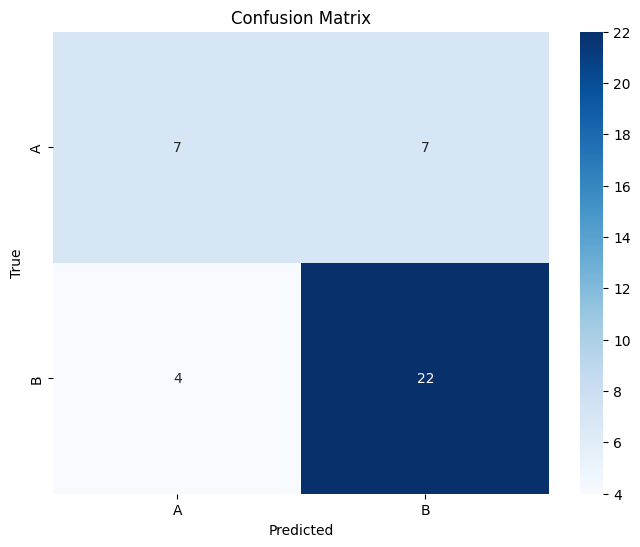

In [ ]:
# prompt: plot a confusion matrix for the results we get in the above cell.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test1 and y_pred are defined from the previous code cell
cm = confusion_matrix(y_test1, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

X = updated_df.drop(columns=['Patient_ID', 'V03KL', 'V00XRKL'])
y = updated_df['V00XRKL']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cv_scores = cross_val_score(model, X, y, cv=10)  # 10-fold cross-validation
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Cross-validation scores: [0.45       0.4        0.35       0.3        0.2        0.35
 0.15       0.26315789 0.47368421 0.36842105]
Mean cross-validation score: 0.33052631578947367
ROC AUC score: 0.6213344084643426


In [ ]:
import warnings
warnings.filterwarnings('ignore')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

cv_scores = cross_val_score(best_model, X, y, cv=10)
mean_cv_score = np.mean(cv_scores)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test), multi_class='ovr')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {mean_cv_score}")
print(f"ROC AUC score: {roc_auc}")

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Cross-validation scores: [0.5        0.4        0.3        0.2        0.3        0.35
 0.2        0.31578947 0.42105263 0.47368421]
Mean cross-validation score: 0.3460526315789474
ROC AUC score: 0.624600534242804


## KL grade prediction using CNN Model

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder, StandardScaler

X = updated_df.drop(columns=['Patient_ID', 'V03KL', 'V00XRKL'])
y = updated_df['V03KL']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax')) # Output layer with softmax for multi-class

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.6546 - loss: 0.6412 - val_accuracy: 0.8125 - val_loss: 0.4999
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6692 - loss: 0.6095 - val_accuracy: 0.7500 - val_loss: 0.5738
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7113 - loss: 0.5678 - val_accuracy: 0.8125 - val_loss: 0.5351
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6781 - loss: 0.5318 - val_accuracy: 0.6875 - val_loss: 0.5554
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7365 - loss: 0.5130 - val_accuracy: 0.6875 - val_loss: 0.5856
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7933 - loss: 0.4898 - val_accuracy: 0.6875 - val_loss: 0.5855
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8073 - loss: 0.4778 - val_accuracy: 0.6875 - val_loss: 0.6063
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8213 - loss: 0.4493 - val_accuracy: 0.6875 - val_loss: 0.6220
Epoch 

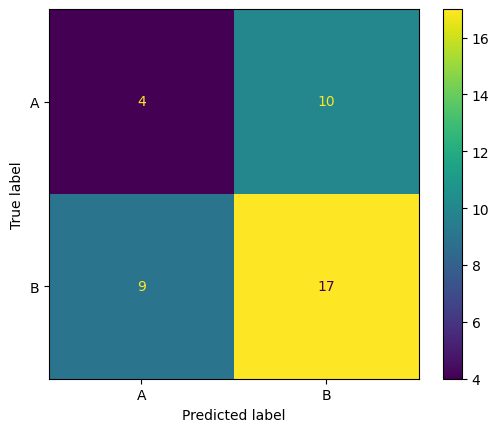

              precision    recall  f1-score   support

           0       0.31      0.29      0.30        14
           1       0.63      0.65      0.64        26

    accuracy                           0.53        40
   macro avg       0.47      0.47      0.47        40
weighted avg       0.52      0.53      0.52        40



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred_classes))

In [ ]:
X = updated_df.drop(columns=['Patient_ID', 'V03KL'])
y = updated_df['V03KL']

le = LabelEncoder()
y = le.fit_transform(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax')) # Output layer with softmax for multi-class

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.5151 - loss: 0.7087 - val_accuracy: 0.8125 - val_loss: 0.4728
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6786 - loss: 0.5755 - val_accuracy: 0.8125 - val_loss: 0.5112
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7235 - loss: 0.5593 - val_accuracy: 0.7500 - val_loss: 0.5627
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7644 - loss: 0.5368 - val_accuracy: 0.7500 - val_loss: 0.5275
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7738 - loss: 0.4888 - val_accuracy: 0.8125 - val_loss: 0.5045
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7454 - loss: 0.4571 - val_accuracy: 0.7500 - val_loss: 0.5022
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8212 - loss: 0.4144 - val_accuracy: 0.6875 - val_loss: 0.5336
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8546 - loss: 0.4332 - val_accuracy: 0.6875 - val_loss: 0.5330

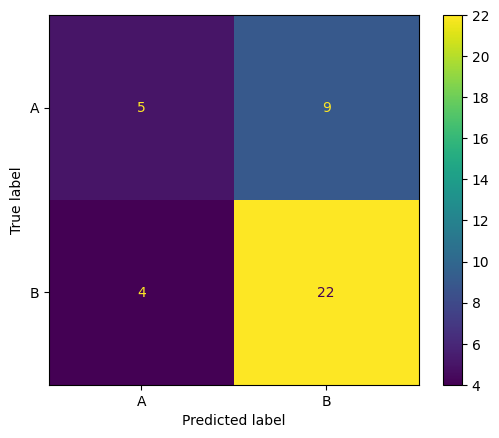

              precision    recall  f1-score   support

           0       0.56      0.36      0.43        14
           1       0.71      0.85      0.77        26

    accuracy                           0.68        40
   macro avg       0.63      0.60      0.60        40
weighted avg       0.66      0.68      0.65        40



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()
plt.show()

print(classification_report(y_test, y_pred_classes))

This code can be tested for all the other datasets too. which we have generated as feature vectors for Step = 2 & Step = 3.